# SDND Project 3 - Traffic Sign Recognition Classifier

## 0. Load the Data

In [1]:
import pickle

In [2]:
training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## 1. Dataset Summary

In [3]:
import matplotlib.pyplot as plt
import random

In [4]:
# -- Number of samples -- #
n_train = len(X_train)   
n_valid = len(X_valid)   
n_test = len(X_test)     

# -- Shape of a traffic sign image -- # 
image_shape = X_train[0].shape        

# -- Number of classes -- #
n_classes = len(set(y_train)) 

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of Dataset - TBA

17


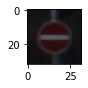

In [5]:
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## 2. Model Architecture

### 2.1. Data pre-processing

In [6]:
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import random

In [12]:
def Preprocess_Images(X, y):
    print("[1-0] Preprocessing Start!")
    
    augmented = []
    for i in range(len(X)):
        
        seed = (i, 0)
        image = tf.cast(X[i], tf.float32)
        image = (image / 255.0)
        
        flag = random.randint(0, 9)
        
        if (flag <= 5):
            result = ((image * 255) - 128) / 128
            augmented.append(result)
            
        if (flag == 6):
            flip_h = tf.image.flip_left_right(image)
            result = ((flip_h * 255) - 128) / 128
            augmented.append(result)
            
        if (flag == 7):
            flip_v = tf.image.flip_up_down(image)
            result = ((flip_v * 255) - 128) / 128
            augmented.append(result)
            
        if (flag == 8):
            bright = tf.image.stateless_random_brightness(image, 0.3, seed)
            result = ((bright * 255) - 128) / 128
            augmented.append(result)
            
        if (flag == 9):
            contrast = tf.image.stateless_random_contrast(image, 0, 2, seed)
            result = ((contrast * 255) - 128) / 128
            augmented.append(result)

    print("[1-1] Preprocessing Done!")
    return augmented, y

In [13]:
# -- 2.1.1. Shuffle the datasets. -- # 
X_train_sf, y_train_sf = shuffle(X_train, y_train)
X_valid_sf, y_valid_sf = shuffle(X_valid, y_valid)
X_test_sf, y_test_sf = shuffle(X_test, y_test)

# -- 2.1.2. Data augmentation & normalization. -- #
X_train_pp, y_train_pp = Preprocess_Images(X_train_sf, y_train_sf) 

[1-0] Preprocessing Start!
[1-1] Preprocessing Done!


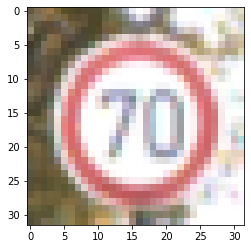

In [16]:
tst1 = X_valid_pp[12]*128+128
plt.imshow(np.uint8(tst1))

### 2.2. LeNet-5

In [25]:
import tensorflow.compat.v1 as v1

def LeNet5(X):
    
    # - Random W & b. - # 
    mu = 0
    sigma = 0.1
    
    # - L1: Conv. Input: 32x32x3. Output: 28x28x6. - #
    conv1_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(X, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    
    # - L1 Pooling. Input: 28x28x6. Output: 14x14x6. - #
    conv1   = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # - L2: Conv. Input: 14x14x6. Output: 10x10x16. - # 
    conv2_W = tf.Variable(tf.random.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2   = tf.nn.relu(conv2)
    
    # - L2 Pooling. Input: 10x10x16. Output: 5x5x16. - # 
    conv2   = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # - L2 Flatten. Input: 5x5x16. Output: 400. - #
    fc0     = v1.flatten(conv2)
    
    # - L3: Fully connected. Input: 400. Output: 120. - #
    fc1_W   = tf.Variable(tf.random.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b   = tf.Variable(tf.zeros(120))
    fc1     = tf.matmul(fc0, fc1_W) + fc1_b
    fc1     = tf.nn.relu(fc1)
    
    # - L4: Fully connected. Input: 120. Output: 84. - #
    fc2_W   = tf.Variable(tf.random.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b   = tf.Variable(tf.zeros(84))
    fc2     = tf.matmul(fc1, fc2_W) + fc2_b
    fc2     = tf.nn.relu(fc2)
    
    # - L5: Fully connected. Input: 84. Output: 43. - # 
    fc3_W   = tf.Variable(tf.random.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b   = tf.Variable(tf.zeros(10))
    fc3     = tf.matmul(fc2, fc3_W) + fc3_b
    
    logits  = fc3
    
    return logits

In [26]:
EPOCHS = 20
BATCH_SIZE = 128

In [242]:


# with g.as_default():
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
eta = 0.001
logits = LeNet5(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = eta)
training_operation = optimizer.minimize(loss_operation)